In [1]:
import pandas as pd

# Load the customer and transaction data
customers_df = pd.read_csv('/Customers.csv')
transactions_df = pd.read_csv('/Transactions.csv')

# Check the first few rows of both dataframes
print(customers_df.head())
print(transactions_df.head())

# Merge customers and transactions data on CustomerID
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

# Aggregate data by CustomerID:
# Calculate total spend and number of transactions per customer
customer_segments = merged_df.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'nunique'),
    region=('Region', 'first')
).reset_index()

# Check the first few rows of the resulting DataFrame
print(customer_segments.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  
  CustomerID  total_spend  num_transactions         region
0      C00

In [2]:
from sklearn.preprocessing import StandardScaler

# Select the relevant columns for clustering
X = customer_segments[['total_spend', 'num_transactions']]

# Scale the data (important for algorithms like K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the scaled data
print(X_scaled[:5])


[[-0.06170143 -0.01145819]
 [-0.87774353 -0.46749414]
 [-0.40585722 -0.46749414]
 [ 1.03254704  1.35664965]
 [-0.78392861 -0.92353008]]


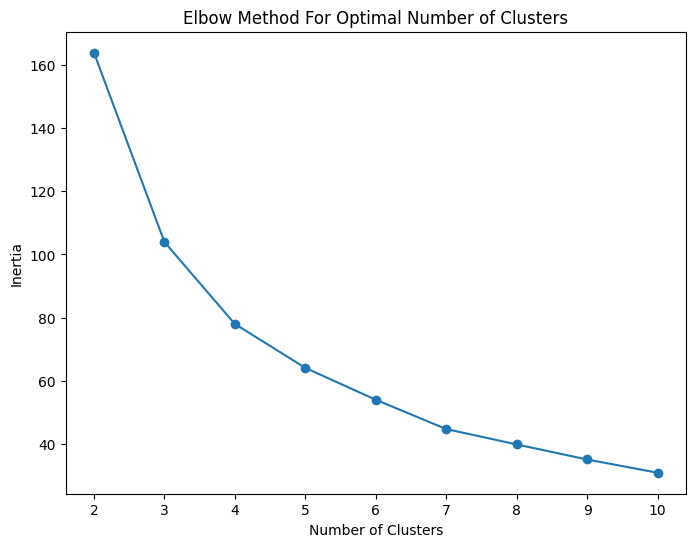

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Number of clusters to test
n_clusters_range = range(2, 11)

# Store the clustering results
inertia = []
silhouette_scores = []

# Run K-Means for different numbers of clusters
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method to determine the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [4]:
from sklearn.metrics import davies_bouldin_score

# Choose the number of clusters (example: 4)
n_clusters_optimal = 4

# Apply K-Means clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, random_state=42)
y_kmeans = kmeans_optimal.fit_predict(X_scaled)

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(X_scaled, y_kmeans)
print(f"DB Index: {db_index:.4f}")


DB Index: 0.8595


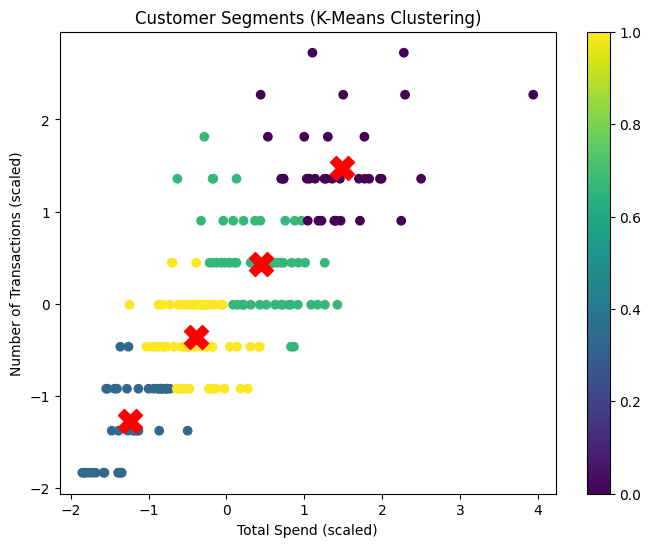

In [5]:
# Plot the clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, cmap='viridis')
plt.scatter(kmeans_optimal.cluster_centers_[:, 0], kmeans_optimal.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.title('Customer Segments (K-Means Clustering)')
plt.xlabel('Total Spend (scaled)')
plt.ylabel('Number of Transactions (scaled)')
plt.colorbar()
plt.show()


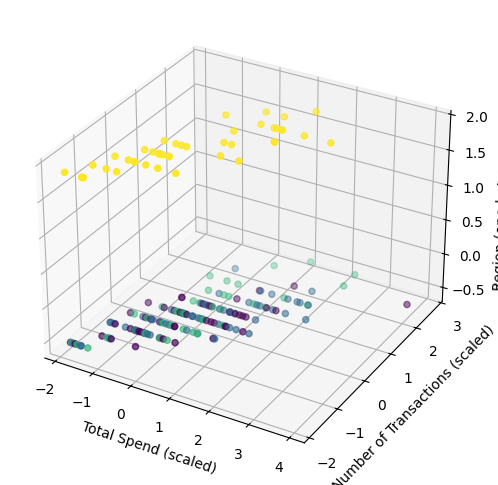

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# Add more features for 3D visualization (e.g., add 'region' or other features)
X_extended = customer_segments[['total_spend', 'num_transactions', 'region']]  # Added 'region' column

# One-hot encode the 'region' column
X_extended = pd.get_dummies(X_extended, columns=['region'], prefix=['region'])

# Scale the data
X_scaled_extended = scaler.fit_transform(X_extended)

# Perform KMeans clustering
kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, random_state=42)
y_kmeans = kmeans_optimal.fit_predict(X_scaled_extended)

# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Use the first three columns for the 3D scatter plot
ax.scatter(X_scaled_extended[:, 0], X_scaled_extended[:, 1], X_scaled_extended[:, 2], c=y_kmeans, cmap='viridis')

ax.set_xlabel('Total Spend (scaled)')
ax.set_ylabel('Number of Transactions (scaled)')
ax.set_zlabel('Region (one-hot encoded)') # Updated z-axis label

plt.show()